# Predictive Analytics Modeling Exercise

In [1]:
# install Tensorflow if necessary
#pip install tensorflow
#pip install keras
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.3.0


In [2]:
from tensorflow import keras

In [3]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
sns.set(style="whitegrid")
%matplotlib inline

## LOADING DATASETS

The dataset consists of 12073 samples in the learning set and 5366 samples in the prediction set. There are 79 variables drawn from different databases, which is why they are split between ‘Group A’ and ‘Group B’ files. The code variable is a categorical variable. The zip variable contains zip codes. Remaining variables are a mix of continuous and categorical variables. Some features include missing values. The id column is a unique sample identifier and hence not a variable.

In [4]:
# import GroupA files
GrA_train = pd.read_csv("featuresGroupAlearning.csv")
test_GrA = pd.read_csv("featuresGroupAprediction.csv")
print(GrA_train.shape)
#GrA_train.head()

(12073, 19)


In [5]:
print(test_GrA.shape)

(5366, 19)


### 1. Exploratory Data Analysis

#### 1.1 Group A files

In [6]:
# Explore the features available in dataframe
print(GrA_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12073 entries, 0 to 12072
Data columns (total 19 columns):
id     12073 non-null object
a00    12069 non-null float64
a01    12073 non-null float64
a02    11945 non-null float64
a03    11944 non-null float64
a04    11940 non-null float64
a05    11952 non-null float64
a06    11951 non-null float64
a07    11936 non-null float64
a08    11958 non-null float64
a09    11967 non-null float64
a10    11971 non-null float64
a11    11937 non-null float64
a12    12070 non-null float64
a13    11960 non-null float64
a14    12071 non-null float64
a15    12068 non-null float64
a16    11945 non-null float64
a17    11931 non-null float64
dtypes: float64(18), object(1)
memory usage: 1.8+ MB
None


In [7]:
# check the volumn of missing data 
def check_missing_df(df):
    # look at how many missing values for the columns
    missing_values_count= df.isnull().sum()
    missing_values_percentage=np.round(df.isnull().sum()/df.shape[0]*100,2)

    #show it in dataframe
    data = {'Number_missing':missing_values_count, 'Missing_percentage':missing_values_percentage} 
    
    # Create DataFrame 
    missing_info = pd.DataFrame(data) 
    
    # Print the output. 
    display(missing_info.sort_values('Missing_percentage',ascending = False))

In [9]:
#check_missing_df(GrA_train)

In [10]:
#check_missing_df(test_GrA)

In [11]:
# summary statistics
# GrA_train.describe()

In [12]:
#test_GrA.describe()

Checking the missing data inside the dataset

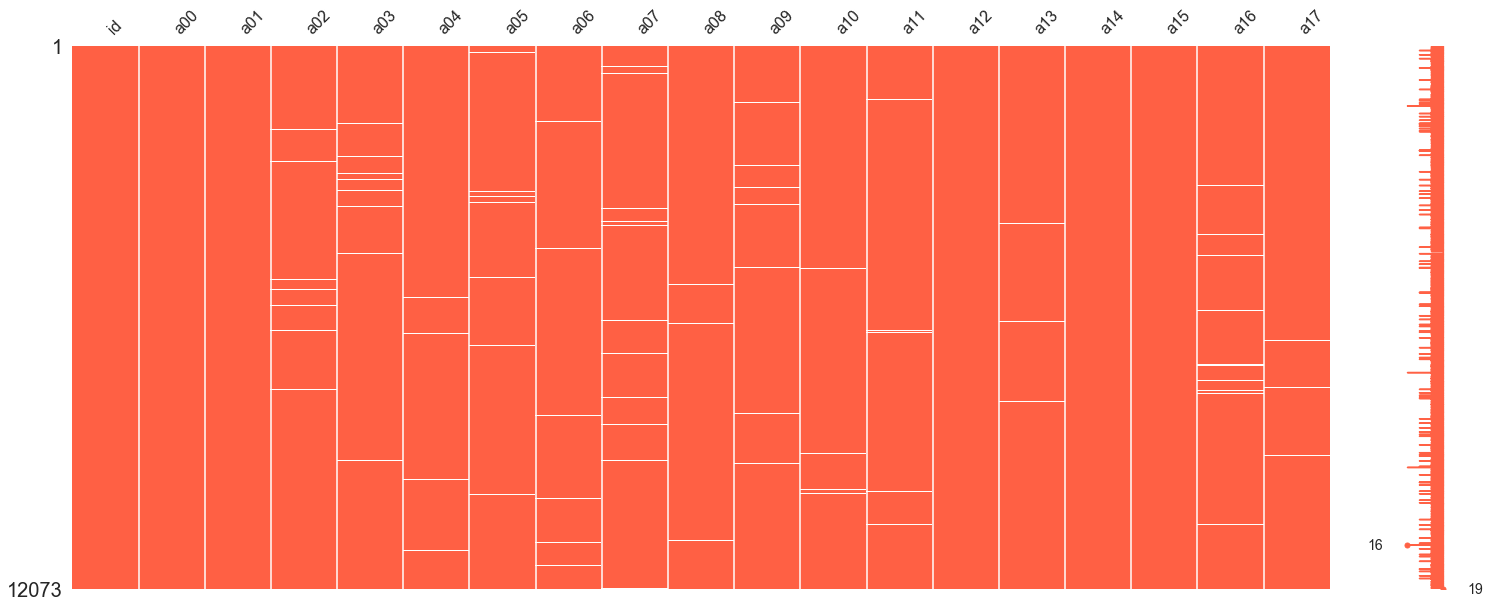

In [13]:
#pip install missingno
import missingno as msno
msno.matrix(GrA_train, color=(1, 0.38, 0.27))

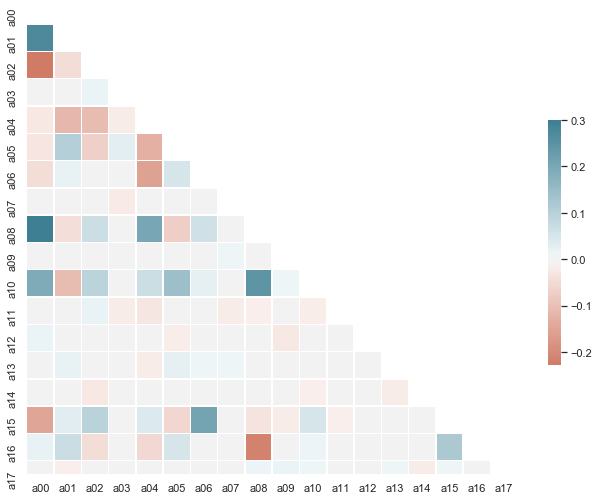

In [14]:
# Compute the correlation matrix
corr = GrA_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This map shows that dataset have low correlation between 18 variable.

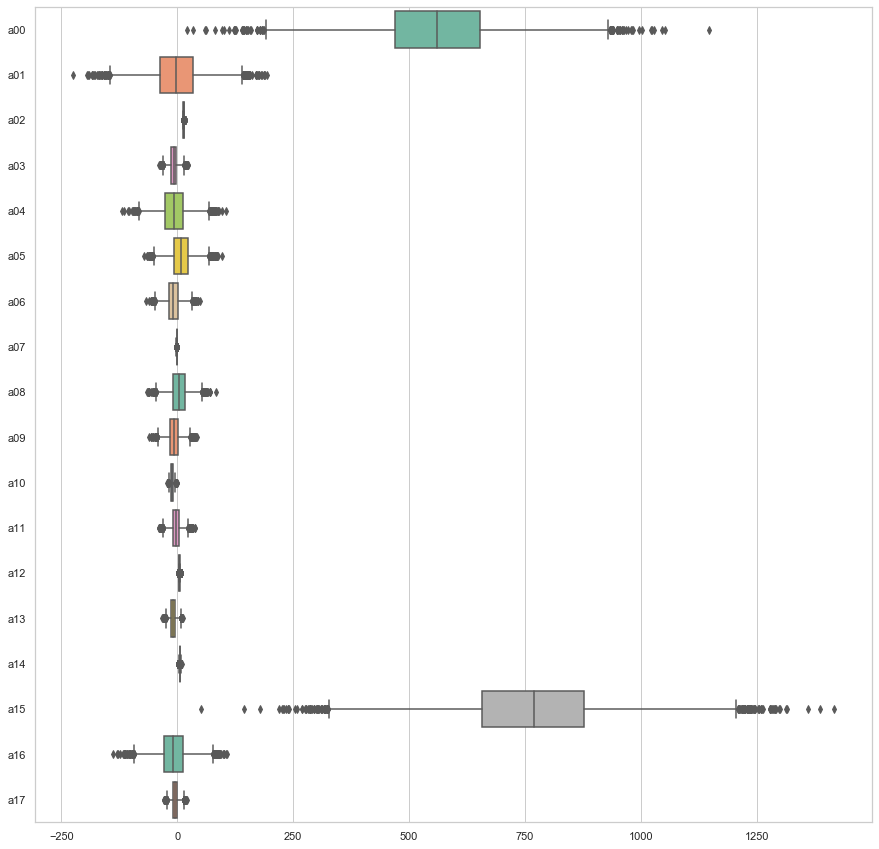

In [15]:
plt.figure(figsize=(15,15))
sns.boxplot(data=GrA_train, orient="h", palette="Set2")

#### Imputation missing data
The a00 and a15 are integer, not float number. Before changing the type of data, we need to fill missing data for these variablea. Because they are interger number, I choose median to replace NA.

In [16]:
# filling NA for train dataset
values = {'a00': 561, 'a15': 769}
GrA_train = GrA_train.fillna(value=values)

In [17]:
type(GrA_train.a00)

pandas.core.series.Series

In [18]:
# filling NA for train dataset
values1 = {'a00': 565, 'a15': 776}
test_GrA = test_GrA.fillna(value=values1)

In [19]:
# create list of column need to convert to interger type
cols = ['a00', 'a15']

# loop to change each column to interger type
for col in cols:
    GrA_train[col] = GrA_train[col].astype('int',copy=False)
    test_GrA[col] = test_GrA[col].astype('int',copy=False)

The a12 and a14 are categorical type, not numeric, so we need to change the type of data. I choose the most frequency type from count value table to fill the NA for these variables.

In [20]:
#GrA_train.a12.value_counts(dropna=False)

In [21]:
#GrA_train.a14.value_counts(dropna=False)

In [22]:
# filling NA for train dataset
values2 = {'a12': 4, 'a14': 6}
GrA_train = GrA_train.fillna(value=values2)

In [23]:
#test_GrA.a12.value_counts(dropna=False)

In [24]:
#test_GrA.a14.value_counts(dropna=False)

In [25]:
# filling NA for predict dataset
test_GrA = test_GrA.fillna(value=values2)

In [26]:
# create list of column need to convert to category type
cats = ['a12', 'a14']

# loop to change each column to interger type
for col in cats:
    GrA_train[col] = GrA_train[col].astype('int',copy=False)
    test_GrA[col] = test_GrA[col].astype('int',copy=False)

In [27]:
type(GrA_train.a12)

pandas.core.series.Series

For other columns, I'm going to use mean value to fill NA because we can see not much different between mean and median in descriptive table and boxplot.

In [28]:
GrA_train.columns

Index(['id', 'a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17'],
      dtype='object')

In [29]:
#GrA_train[['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
#       'a09', 'a10', 'a11', 'a13', 'a16', 'a17']].head()

In [30]:
# create list of column need to fill missing value
cols = ['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08',
       'a09', 'a10', 'a11', 'a13', 'a16', 'a17']

# loop to fill each column 
for col in cols:
    GrA_train[col].fillna(GrA_train[col].mean(), inplace=True)
    test_GrA[col].fillna(test_GrA[col].mean(), inplace=True)

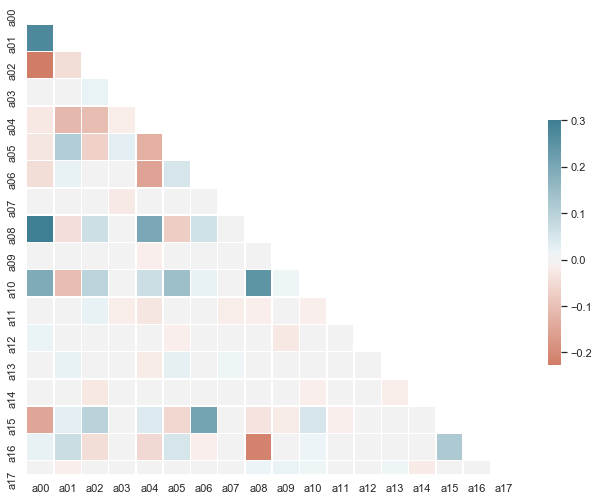

In [31]:
# Compute the correlation matrix
corr = GrA_train.corr(method='pearson', min_periods=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

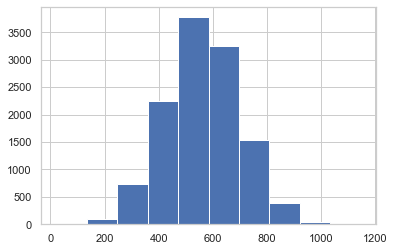

In [32]:
GrA_train.a00.hist()

#### 1.2 GroupB files

In [33]:
# import Group8 files
GrB_train = pd.read_csv("featuresGroupBlearning.csv")
test_GrB = pd.read_csv("featuresGroupBprediction.csv")
print(GrB_train.shape)
#GrB_train.head()

(12073, 62)


In [33]:
# Explore the features available in dataframe
# print(GrB_train.info())

In [34]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(check_missing_df(GrB_train))

In [35]:
# summary statistics for Group B Learning dataset
#GrB_train.describe(percentiles=[]).transpose()

In [36]:
#GrB_train.code.value_counts(dropna=False)

In [37]:
#test_GrB.code.value_counts(dropna=False)

In [38]:
# most frequent value of code is 1000009
values3 = {'code': 1000009}
GrB_train = GrB_train.fillna(value=values3)
test_GrB = test_GrB.fillna(value=values3)

In [39]:
# convert label to a numerical variable
#GrB_train[['code']] = GrB_train[['code']].astype('str').replace(regex={'1000009.0': '9','1000002.0': '2', 
#                                                                       '1000003.0': '3','1000001.0': '1', 
#                                                                       '1000008.0': '8','1000005.0': '5',
#                                                                      '1000007.0': '7','1000000.0': '0',
#                                                                       '1000006.0': '6','1000004.0': '4'})
#test_GrB[['code']] = test_GrB[['code']].astype('str').replace(regex={'1000009.0': '9','1000002.0': '2', 
#                                                                       '1000003.0': '3','1000001.0': '1', 
#                                                                       '1000008.0': '8','1000005.0': '5',
#                                                                       '1000007.0': '7','1000000.0': '0',
#                                                                       '1000006.0': '6','1000004.0': '4'})

In [40]:
# create list of column need to fill missing value
cols = ['b07', 'b25']

# loop to fill each column 
for col in cols:
    GrB_train[col].fillna(GrB_train[col].median(), inplace=True)
    test_GrB[col].fillna(test_GrB[col].median(), inplace=True)

In [41]:
#print(GrB_train.b13.value_counts(dropna=False))
#print(test_GrB.b13.value_counts(dropna=False))

In [42]:
#print(test_GrB.b14.value_counts(dropna=False))
#print(GrB_train.b14.value_counts(dropna=False))

In [43]:
#print(GrB_train.b39.value_counts(dropna=False))
#print(test_GrB.b39.value_counts(dropna=False))

In [44]:
values4 = {'b13': 5, 'b14': 6, 'b39': 6}
GrB_train = GrB_train.fillna(value=values4)
test_GrB = test_GrB.fillna(value=values4)

In [45]:
# create list of column need to convert
colus = ['b07', 'b13', 'b14','b25', 'b39']

# loop to change each column to interger type
for col in colus:
    GrB_train[col] = GrB_train[col].astype('int',copy=False)
    test_GrB[col] = test_GrB[col].astype('int',copy=False)

Explore b21 variable 

In [46]:
#GrB_train.b21.value_counts(dropna=False)

In [47]:
values5 = {'b21': 'Central'}
GrB_train = GrB_train.fillna(value=values5)
test_GrB = test_GrB.fillna(value=values5)

In [48]:
# convert label to a numerical variable - train data
#GrB_train[['b21']] = GrB_train[['b21']].replace(dict.fromkeys(['Central'], '1'))
#GrB_train[['b21']] = GrB_train[['b21']].replace(dict.fromkeys(['West'], '2'))
#GrB_train[['b21']] = GrB_train[['b21']].replace(dict.fromkeys(['East'], '3'))

# convert label to a numerical variable - prediction data
#test_GrB[['b21']] = test_GrB[['b21']].replace(dict.fromkeys(['Central'], '1'))
#test_GrB[['b21']] = test_GrB[['b21']].replace(dict.fromkeys(['West'], '2'))
#test_GrB[['b21']] = test_GrB[['b21']].replace(dict.fromkeys(['East'], '3'))

In [49]:
#GrB_train.b21.value_counts(dropna=False)

Explore b34 and b58 variables

In [50]:
#GrB_train.b34.unique()

In [51]:
# clean name of the day to standard form
# training data
GrB_train[['b34']] = GrB_train[['b34']].replace(dict.fromkeys(['mon', 'mon.', 'Monday', 'monday', 'Mon'], '2'))
GrB_train[['b34']] = GrB_train[['b34']].replace(dict.fromkeys(['tuesday', 'tue', 'Tue.', 'Tuesday', 'tue.','Tue'], '3'))
GrB_train[['b34']] = GrB_train[['b34']].replace(dict.fromkeys(['Wed.','wednesday', 'Wed', 'Wednesday','wed','Wendsday', 'wendsday'], '4'))
GrB_train[['b34']] = GrB_train[['b34']].replace(dict.fromkeys(['thu', 'thu.','thursday', 'Thursday', 'Thu', 'Thu.', 'thurday'], '5'))
GrB_train[['b34']] = GrB_train[['b34']].replace(dict.fromkeys(['fri', 'friday', 'Friday','fri.','Fri', 'Fri.'], '6'))
# prediction data
test_GrB[['b34']] = test_GrB[['b34']].replace(dict.fromkeys(['mon', 'mon.', 'Monday', 'monday', 'Mon'], '2'))
test_GrB[['b34']] = test_GrB[['b34']].replace(dict.fromkeys(['Teusday','tuesday', 'tue', 'Tue.', 'Tuesday', 'tue.','Tue'], '3'))
test_GrB[['b34']] = test_GrB[['b34']].replace(dict.fromkeys(['Wed.','wednesday', 'Wed', 'Wednesday','wed','Wendsday', 'wendsday'], '4'))
test_GrB[['b34']] = test_GrB[['b34']].replace(dict.fromkeys(['thu', 'thu.','thursday', 'Thursday', 'Thu', 'Thu.', 'thurday'], '5'))
test_GrB[['b34']] = test_GrB[['b34']].replace(dict.fromkeys(['fri', 'friday', 'Friday','fri.','Fri', 'Fri.'], '6'))

In [52]:
#print(GrB_train.b34.value_counts(dropna=False))
#print(test_GrB.b34.value_counts(dropna=False))

In [53]:
# most frequent value of day is Wed
values6 = {'b34': '4'}
GrB_train = GrB_train.fillna(value=values6)
test_GrB = test_GrB.fillna(value=values6)

In [54]:
#GrB_train.b58.unique()

In [55]:
# clean name of the day to standard form
# training data
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['jan.', 'jan'], '1'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['february','Feb.', 'feb', 'February', 'Feb','feb.'], '2'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['March','Mar.', 'mar.','mar','march', 'Mar', 'Marhc'], '3'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['apr.','April','apr', 'april','Apr','Apr.','Apirl'], '4'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['May','may'], '5'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['jun', 'Jun.', 'Jun', 'June', 'june'], '6'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['jul',], '7'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['Aug.', 'Aug','August','Augest', 'aug.', 'aug','august'], '8'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['sep.', 'sept.', 'sep', 'Sep','sept','september', 'Sept.','Sep.'], '9'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['oct','Oct.', 'October','oct.','october','Oct'], '10'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['Nov.', 'nov', 'nov.','november','November','Nov'], '11'))
GrB_train[['b58']] = GrB_train[['b58']].replace(dict.fromkeys(['december', 'dec.', 'dec','December'], '12'))

# prediction dataset
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['jan.', 'jan', 'January','Jan'], '1'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['february','Feb.', 'feb', 'February', 'Feb','feb.'], '2'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['March','Mar.', 'mar.','mar','march', 'Mar', 'Marhc'], '3'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['apr.','April','apr', 'april','Apr','Apr.','Apirl'], '4'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['May','may'], '5'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['jun', 'Jun.', 'Jun', 'June', 'june'], '6'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['jul',], '7'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['Aug.', 'Aug','August','Augest', 'aug.', 'aug','august'], '8'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['sep.', 'sept.', 'sep', 'Sep','sept','september', 'Sept.','Sep.'], '9'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['oct','Oct.', 'October','oct.','october','Oct'], '10'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['Nov.', 'nov', 'nov.','november','November', 'Nov'], '11'))
test_GrB[['b58']] = test_GrB[['b58']].replace(dict.fromkeys(['december', 'dec.', 'dec','December','Dec.','Dec'], '12'))

In [56]:
# most frequent value of Month is Jul
values6 = {'b58': '7'}
GrB_train = GrB_train.fillna(value=values6)
test_GrB = test_GrB.fillna(value=values6)

##### Convert zip code to string

In [57]:
GrB_train['zip'] = GrB_train['zip'].astype(str).str.zfill(5)

In [58]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(GrB_train['zip'])

In [59]:
test_GrB['zip'] = test_GrB['zip'].astype(str).str.zfill(5)

In [60]:
GrB_train.columns

Index(['id', 'code', 'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07',
       'b08', 'b09', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17',
       'b18', 'b19', 'b20', 'b21', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27',
       'b28', 'b29', 'b30', 'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37',
       'b38', 'b39', 'b40', 'b41', 'b42', 'b43', 'b44', 'b45', 'b46', 'b47',
       'b48', 'b49', 'b50', 'b51', 'b52', 'b53', 'b54', 'b55', 'b56', 'b57',
       'b58', 'zip'],
      dtype='object')

In [61]:
# create list of column need to fill missing value
cols1 = ['b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06',
       'b08', 'b09', 'b10', 'b11', 'b12', 'b15', 'b16', 'b17',
       'b18', 'b19', 'b20', 'b22', 'b23', 'b24', 'b26', 'b27',
       'b28', 'b29', 'b30', 'b31', 'b32', 'b33', 'b35', 'b36', 'b37',
       'b38', 'b40', 'b41', 'b42', 'b43', 'b44', 'b45', 'b46', 'b47',
       'b48', 'b49', 'b50', 'b51', 'b52', 'b53', 'b54', 'b55', 'b56', 'b57']

# loop to fill each column 
for col in cols1:
    GrB_train[col].fillna(GrB_train[col].mean(), inplace=True)
    test_GrB[col].fillna(test_GrB[col].mean(), inplace=True)

In [62]:
# create list of column need to convert
colus = ['code', 'b21', 'b34','b58', 'zip']

# loop to change each column to interger type
for col in colus:
    GrB_train[col] = GrB_train[col].astype('int',copy=False)
    test_GrB[col] = test_GrB[col].astype('int',copy=False)

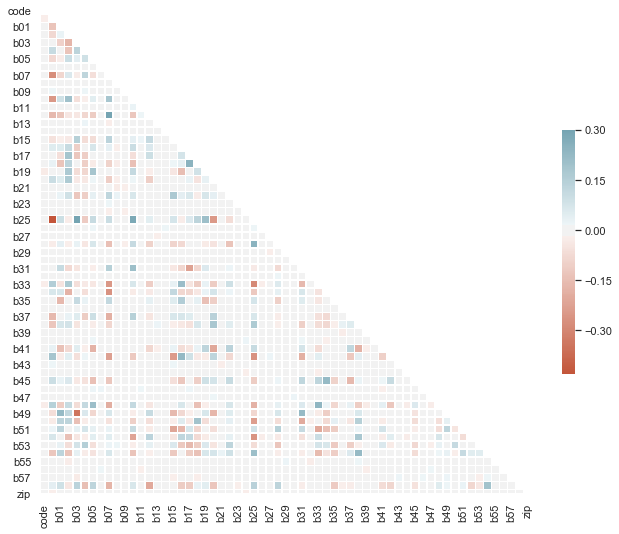

In [63]:
# Compute the correlation matrix
corr = GrB_train.corr(method='pearson', min_periods=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

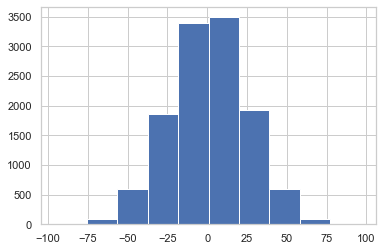

In [64]:
GrB_train.b12.hist()

### 1.2 responseLearning y

A classification response y is provided for learning set samples, with the positive class labeled 1 and the negative class labeled 0. 

In [65]:
target_train = pd.read_csv("responseLearning.csv")
#target_train.head()

In [66]:
target_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12073 entries, 0 to 12072
Data columns (total 2 columns):
id    12073 non-null object
y     12073 non-null int64
dtypes: int64(1), object(1)
memory usage: 188.8+ KB


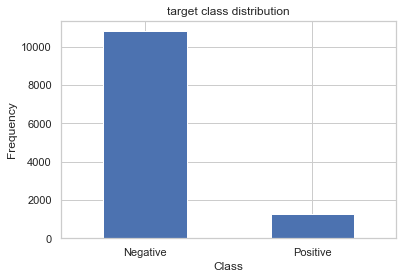

In [67]:
count_classes = pd.value_counts(target_train['y'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
rcParams['figure.figsize'] = 14, 8
plt.title("target class distribution")
LABELS = ["Negative", "Positive"]
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [68]:
Negative = target_train[target_train.y == 0]
Positive = target_train[target_train.y == 1]

In [69]:
Negative.shape

(10806, 2)

In [70]:
Positive.shape

(1267, 2)

The classification response y is imbalanced, positive class (1) is only equal to 10% of negative class (0). 

### 2. Combine datasets

#### 2.1 Training data

In [71]:
traindata = pd.merge(pd.merge(GrA_train,GrB_train,on='id'),target_train,on='id')
#traindata.head()

In [72]:
traindata.shape

(12073, 81)

In [73]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(check_missing_df(traindata))

EDA on full training dataset

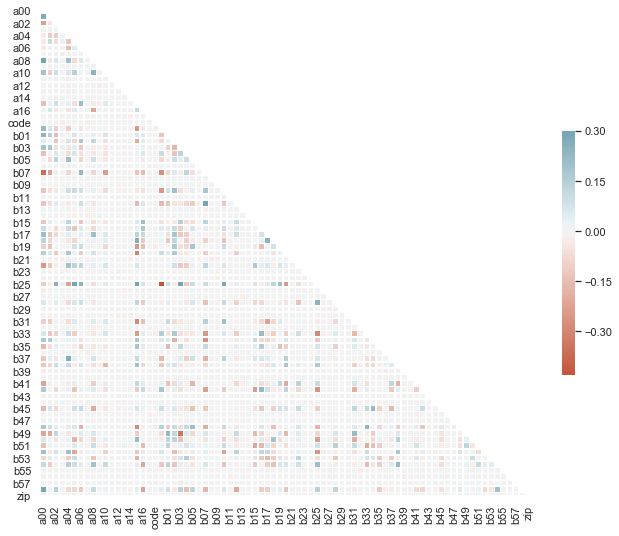

In [74]:
# Compute the correlation matrix
corr = traindata.iloc[:, 1:80].corr(method='pearson', min_periods=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [75]:
#traindata.to_csv('Traindata_NW.csv', encoding='utf-8', index=False)

### 2.2 Prediction dataset

In [76]:
Pred_data = pd.merge(test_GrA,test_GrB,on='id')
#Pred_data.head()

In [77]:
Pred_data.shape

(5366, 80)

In [78]:
#Pred_data.to_csv('Pred_data_NW.csv', encoding='utf-8', index=False)

# MODELING

   This dataset contains one prediction variable and 79 predictor variables that is large number of predictors. We can run PCA to weight the predictors.
   
   The prediction y is imbalanced variable so we need to find the way to make it be balanced. If not, the model will predict value 0 most of the time for y.
   This case is fit for anomaly dectection. My solution contains various ways:
   1. Density-based anomaly detection is based on the k-nearest neighbors algorithm.
      Clustering-based anomaly detection with K-means or DBSCAN
   2. Decision Trees, Random Forests and Logistic Regression. A support vector machine is another effective technique for detecting anomalies. Because our dataset is imbalanced (1:10), we should oversampling class 1 with Synthetic Minority Oversampling Technique (SMOTE) before we apply these techniques above.
   3. The efficient neural network to detect anomalies is using autoencoders. In order to detect anomalies autoencoder needs to be trained in unsupervised (or semi-supervised) fashion on data free of anomalies. The trained model is then used to predict normal data mixed with anomalies. Cases which the model fails to predict are marked as anomalies.

### 1. BASIC MODELING WITH DATASET

In [79]:
# Create X and y from dataset
from collections import Counter
from sklearn.model_selection import train_test_split
y = traindata.y
X = traindata.iloc[:, 1:80]
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 10806, 1: 1267})


In [80]:
# Run a groupby command on our labels and obtain the mean for each feature
#traindata.groupby('y').mean()

### 1.1 Classification with Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', metrics.classification_report(y_test, predicted))
conf_mat = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.95      3230
           1       0.64      0.13      0.22       392

    accuracy                           0.90      3622
   macro avg       0.77      0.56      0.58      3622
weighted avg       0.87      0.90      0.87      3622

Confusion matrix:
 [[3201   29]
 [ 341   51]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 1.2 Classification with Random Forest Classifier

In [82]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', metrics.classification_report(y_test, predicted))
conf_mat = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      3230
           1       1.00      0.01      0.02       392

    accuracy                           0.89      3622
   macro avg       0.95      0.50      0.48      3622
weighted avg       0.90      0.89      0.84      3622

Confusion matrix:
 [[3230    0]
 [ 389    3]]


### 1.3 Classification with Support Vector Machines Classification

In [83]:
from sklearn import svm
model = svm.SVC(decision_function_shape='ovo')
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', metrics.classification_report(y_test, predicted))
conf_mat = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      3230
           1       0.00      0.00      0.00       392

    accuracy                           0.89      3622
   macro avg       0.45      0.50      0.47      3622
weighted avg       0.80      0.89      0.84      3622

Confusion matrix:
 [[3230    0]
 [ 392    0]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
# Using Linear as kernel:
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train, y_train)

# Obtain model predictions
predicted = lin_clf.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', metrics.classification_report(y_test, predicted))
conf_mat = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      3230
           1       0.76      0.09      0.16       392

    accuracy                           0.90      3622
   macro avg       0.83      0.54      0.55      3622
weighted avg       0.88      0.90      0.86      3622

Confusion matrix:
 [[3219   11]
 [ 358   34]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


With all classification models we use above, the F1-score accuracy is 0.89 - 0.9 but the recall of the minority class in very less. It proves that the model is more biased towards majority class. So, it proves that this is not the best model.
Now, we will apply different imbalanced data handling techniques and see their accuracy and recall results.

## 2. PCA 

In [86]:
RatesData = traindata.iloc[:, 1:79]

In [87]:
from sklearn.decomposition import PCA
from sklearn import linear_model

pca = PCA(svd_solver='full')
pca.fit(RatesData)
#print('Explained variance by factors:\n', pca.explained_variance_.round())

PCA(svd_solver='full')

In [88]:
pca_factors = pd.DataFrame(pca.transform(RatesData), 
                           columns=['pca.f{}'.format(i+1) for i in range(pca.n_components_)], 
                           index=RatesData.index)
#pca_factors.head()

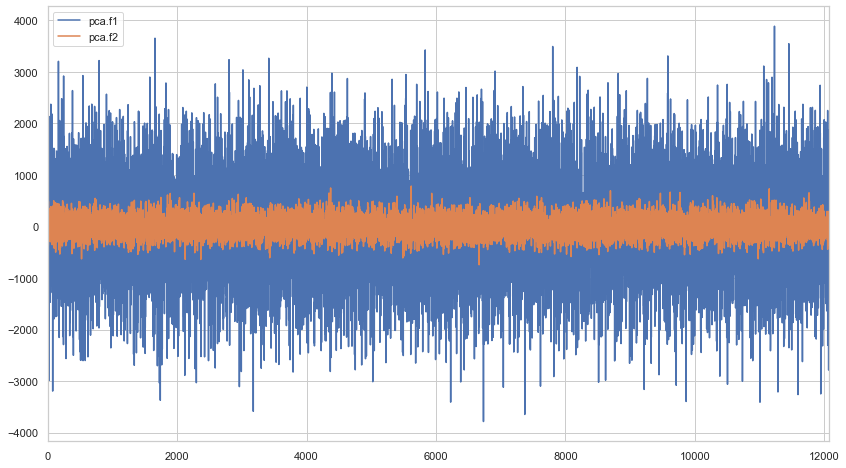

In [89]:
pca_factors[['pca.f1', 'pca.f2']].plot()

I explore more PCA technique in R Markdown file.

## 3. Oversampling and undersampling methods 

## 3.1 Oversampling - Synthetic Minority Oversampling Technique (SMOTE)

In [90]:
!pip install imbalanced-learn

In [91]:
import imblearn
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [92]:
from sklearn.model_selection import train_test_split 
  
# split into 70:30 ration 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 
  
# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (8451, 79)
Number transactions y_train dataset:  (8451,)
Number transactions X_test dataset:  (3622, 79)
Number transactions y_test dataset:  (3622,)


In [93]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

Before OverSampling, counts of label '1': 875
Before OverSampling, counts of label '0': 7576 

After OverSampling, the shape of train_X: (15152, 79)
After OverSampling, the shape of train_y: (15152,) 

After OverSampling, counts of label '1': 7576
After OverSampling, counts of label '0': 7576


In [94]:
# Logistic Regression model
from sklearn.metrics import confusion_matrix, classification_report 
lr1 = LogisticRegression() 
lr1.fit(X_train_res, y_train_res.ravel()) 
predictions = lr1.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      3230
           1       0.24      0.70      0.35       392

    accuracy                           0.72      3622
   macro avg       0.59      0.71      0.59      3622
weighted avg       0.88      0.72      0.77      3622



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [95]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res.ravel()) 
predicted = model.predict(X_test)

# print classification report 
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3230
           1       0.61      0.26      0.37       392

    accuracy                           0.90      3622
   macro avg       0.76      0.62      0.66      3622
weighted avg       0.88      0.90      0.88      3622



In [96]:
!pip install xgboost

In [97]:
# XGBoost Model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_res, y_train_res.ravel()) 
predicted = model.predict(X_test)

# print classification report 
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3230
           1       0.79      0.59      0.67       392

    accuracy                           0.94      3622
   macro avg       0.87      0.79      0.82      3622
weighted avg       0.93      0.94      0.93      3622



In [98]:
# Gaussian Naive Bayes (GaussianNB)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train_res, y_train_res.ravel()) 
predicted = model.predict(X_test)

# print classification report 
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      3230
           1       0.23      0.43      0.30       392

    accuracy                           0.79      3622
   macro avg       0.58      0.63      0.59      3622
weighted avg       0.85      0.79      0.81      3622



In [99]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage
print(percentage)

89.50550815870123


### 3.1* PCA and XGBoost with SMOTE

In [100]:
# Create X and y from dataset
from collections import Counter
from sklearn.model_selection import train_test_split
y = traindata.y
X = traindata.iloc[:, 1:80]
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 10806, 1: 1267})


In [101]:
from sklearn.decomposition import PCA

# initiate PCA
pca = PCA()

# transform / fit

X_transformed = pca.fit_transform(X)
X_transformed.shape

(12073, 79)

In [102]:
# split into 70:30 ration 
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size = 0.3, random_state = 0) 
  
# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (8451, 79)
Number transactions y_train dataset:  (8451,)
Number transactions X_test dataset:  (3622, 79)
Number transactions y_test dataset:  (3622,)


In [103]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

Before OverSampling, counts of label '1': 875
Before OverSampling, counts of label '0': 7576 

After OverSampling, the shape of train_X: (15152, 79)
After OverSampling, the shape of train_y: (15152,) 

After OverSampling, counts of label '1': 7576
After OverSampling, counts of label '0': 7576


In [104]:
# XGBoost Model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_res, y_train_res.ravel()) 
predicted = model.predict(X_test)

# print classification report 
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3230
           1       0.85      0.72      0.78       392

    accuracy                           0.96      3622
   macro avg       0.91      0.85      0.88      3622
weighted avg       0.95      0.96      0.95      3622



The best model is doing PCA to reduction dimentionality before oversampling with SMOTE then applying XGBoostClassifier. 

## 3.2 Undersampling with NearMiss Algorithm

In [105]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel()) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0))) 

Before Undersampling, counts of label '1': 875
Before Undersampling, counts of label '0': 7576 

After Undersampling, the shape of train_X: (1750, 79)
After Undersampling, the shape of train_y: (1750,) 

After Undersampling, counts of label '1': 875
After Undersampling, counts of label '0': 875


In [106]:
# train the model Logistic Regression on train set 
lr2 = LogisticRegression() 
lr2.fit(X_train_miss, y_train_miss.ravel()) 
predictions = lr2.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.97      0.55      0.70      3230
           1       0.19      0.85      0.30       392

    accuracy                           0.58      3622
   macro avg       0.58      0.70      0.50      3622
weighted avg       0.88      0.58      0.66      3622



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [107]:
# train the model Random Forest on train set 
rf2 = RandomForestClassifier(random_state=42) 
rf2.fit(X_train_miss, y_train_miss.ravel()) 
predictions = rf2.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      3230
           1       0.27      0.90      0.41       392

    accuracy                           0.72      3622
   macro avg       0.63      0.80      0.62      3622
weighted avg       0.91      0.72      0.77      3622



With both methods to handle imbalanced dataset, the accuracy rate is same (oversampling) or decrease (undersampling) but the recall of class "1" is increase. The best model for this technique is PCA and XGBoostClassifier with SMOTE that accuracy rate is 0.96

## 3.3 Predict y with PCA, XGBoost and SMOTE 

In [108]:
frames = [traindata, Pred_data]
dataframe = pd.concat(frames)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [112]:
dataframe.shape

(17439, 81)

In [113]:
dataframe = dataframe.drop(['zip'], axis=1)

In [114]:
#dataframe.columns

In [115]:
# initiate PCA
pca = PCA()

# transform / fit

dataframe.iloc[:,:-2] = pca.fit_transform(dataframe.iloc[:,:-2])
dataframe.shape

(17439, 80)

In [116]:
# train dataset
train = dataframe.loc[dataframe.id.isin(traindata.id)]
train.shape

(12073, 80)

In [117]:
# prediction dataset
pred = dataframe.loc[dataframe.id.isin(Pred_data.id)]
pred.shape

(5366, 80)

In [118]:
# Create X and y from dataset
y_train = train.y
X_train = train.iloc[:,:-2]

In [119]:
y_pred = pred.y
X_pred = pred.iloc[:,:-2]

In [120]:
# using SMOTE to balance the dataset
sm = SMOTE(random_state = 42) 
X_res, y_res = sm.fit_sample(X_train, y_train.ravel()) 

# fitting in the model
xg1 = XGBClassifier() 
xg1.fit(X_res, y_res.ravel()) 
y_pred = xg1.predict(X_pred)
pred_prob = xg1.predict_proba(X_pred)

# creating a list of column names 
column_values = ['prob0', 'prob1'] 
  
# creating the dataframe 
df1 = pd.DataFrame(data = pred_prob,  
                  columns = column_values) 

Pred_data['y_hats'] = y_pred
Pred_data['y_hats_prob0'] = df1['prob0']
Pred_data['y_hats_prob1'] = df1['prob1']

In [121]:
Pred_data.y_hats.value_counts(dropna=False)

0.0    4850
1.0     516
Name: y_hats, dtype: int64

In [118]:
#Pred_data[['id','y_hats']].to_csv('predictions_AnhPhan_model1.csv', encoding='utf-8', index=False)

In [119]:
#Pred_data[['id','y_hats_prob0','y_hats_prob1']].to_csv('predictions_AnhPhan_model1_prob.csv', encoding='utf-8', index=False)

## 4. Anomalies Detection using Autoencoders

This approach has two important benefits:
- Imbalance of the data is not a problem: there is plenty of data to train the model
- Anomalies detection is not trained for any particular type of anomaly: anything that is different from normal can be detected

In [125]:
featuresList = [col for col in RatesData]
# Extract the labels from train and test data.
#print('featuresList: ',featuresList)
Train = traindata[featuresList + ['y']]
#print('\nTrain sample: \n')
#Train.head()

Drop column ID since it does not seem to be informative. Drop Zip code column because it has different scale with other variables. The future work should be map the zip to city and state, then convert the value to categorical variables.

In [126]:
featuresList = [col for col in RatesData]
# Extract the labels from train and test data.
#print('featuresList: ',featuresList)
Train = traindata[featuresList + ['y']]
#print('\nTrain sample: \n')
#Train.head()

In [127]:
# create list of column need to convert to category type
cates = ['a12', 'a14', 'code','b13','b14','b21', 'b34','b39','b58']

# loop to change each column to interger type
for col in cates:
    Train[col] = Train[col].astype('category',copy=False)
    Pred_data[col] = Pred_data[col].astype('category',copy=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### One hot encoding
Transform character variables into numeric format using one hot encoding implemented in pd.get_dummies().

In [129]:
Train = pd.get_dummies(Train)
#Train.head()

In [131]:
featuresList = [col for col in Train if col != 'y']
print('featuresList: ',featuresList)
Train = Train[featuresList + ['y']]
#print('\nTrain sample: \n')
#Train.head()

featuresList:  ['a00', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a13', 'a15', 'a16', 'a17', 'b00', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b09', 'b10', 'b11', 'b12', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30', 'b31', 'b32', 'b33', 'b35', 'b36', 'b37', 'b38', 'b40', 'b41', 'b42', 'b43', 'b44', 'b45', 'b46', 'b47', 'b48', 'b49', 'b50', 'b51', 'b52', 'b53', 'b54', 'b55', 'b56', 'b57', 'a12_1', 'a12_2', 'a12_3', 'a12_4', 'a12_5', 'a12_6', 'a12_7', 'a14_1', 'a14_2', 'a14_3', 'a14_4', 'a14_5', 'a14_6', 'a14_7', 'a14_8', 'a14_9', 'a14_10', 'code_0', 'code_1', 'code_2', 'code_3', 'code_4', 'code_5', 'code_6', 'code_7', 'code_8', 'code_9', 'b13_2', 'b13_3', 'b13_4', 'b13_5', 'b13_6', 'b13_7', 'b13_8', 'b13_9', 'b14_2', 'b14_3', 'b14_4', 'b14_5', 'b14_6', 'b14_7', 'b14_8', 'b14_9', 'b14_10', 'b21_1', 'b21_2', 'b21_3', 'b34_2', 'b34_3', 'b34_4', 'b34_5', 'b34_6', 'b39_1', 'b39_2', 'b3

In [150]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()
scaler.fit(Train[featuresList])

StandardScaler()

In [151]:
Train[featuresList] = scaler.transform(Train[featuresList])
#Train.head()

In [152]:
# Split the data into train and test subsets
X_train_split, X_test_split = train_test_split(Train, 
                               test_size=0.2, 
                               shuffle=True, 
                               stratify=Train['y'],
                               random_state=1)

Extract the labels from train and test data.

In [153]:
# Detach the labels from the train and the test datasets
y_train = X_train_split['y']
X_train = X_train_split.drop(['y'], axis=1)

y_test = X_test_split['y']
X_test = X_test_split.drop(['y'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (9658, 144) , shape Y (9658,)
Test: shape X (2415, 144) , shape Y (2415,)


Select the negative value (normal) from the training data to train autoencoder on them.

In [154]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [155]:
print(y_train.shape)
print(X_train.shape)

(9658,)
(9658, 144)


In [156]:
X_trainNorm_val.shape

(8644, 144)

### Creating the model

In [157]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 14
encoder_dim = 7

In [158]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization

def getModel():
    inp = Input(shape=(X_trainNorm_val.shape[1],))
    #d1=Dropout(0.3)(inp)
    bn = BatchNormalization()
    encoder1 = Dense(layer1_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(inp)
    encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
    decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
    decoder2 = Dense(input_dim, activation='linear')(decoder1)
    autoencoder = Model(inp, decoder2)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

autoencoder=getModel()

In [159]:
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 14)                2030      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_6 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_7 (Dense)              (None, 144)               2160      
Total params: 4,407
Trainable params: 4,407
Non-trainable params: 0
_________________________________________________________________


In [160]:
nb_epoch = 150
batch_size = 100
checkpointer = ModelCheckpoint(filepath="autoencoder_2.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

Epoch 1/150
87/87 [==============================] - 0s 2ms/step - loss: 0.9805 - val_loss: 1.0426
Epoch 2/150
87/87 [==============================] - 0s 1ms/step - loss: 0.9526 - val_loss: 1.0221
Epoch 3/150
87/87 [==============================] - 0s 1ms/step - loss: 0.9341 - val_loss: 1.0074
Epoch 4/150
87/87 [==============================] - 0s 1ms/step - loss: 0.9209 - val_loss: 0.9961
Epoch 5/150
87/87 [==============================] - 0s 1ms/step - loss: 0.9102 - val_loss: 0.9862
Epoch 6/150
87/87 [==============================] - 0s 1ms/step - loss: 0.9003 - val_loss: 0.9764
Epoch 7/150
87/87 [==============================] - 0s 1ms/step - loss: 0.8913 - val_loss: 0.9684
Epoch 8/150
87/87 [==============================] - 0s 1ms/step - loss: 0.8846 - val_loss: 0.9626
Epoch 9/150
87/87 [==============================] - 0s 1ms/step - loss: 0.8797 - val_loss: 0.9583
Epoch 10/150
87/87 [==============================] - 0s 1ms/step - loss: 0.8762 - val_loss: 0.9553
Epoch 11/

In [161]:
autoencoder = load_model('autoencoder_2.h5')

### Evaluation

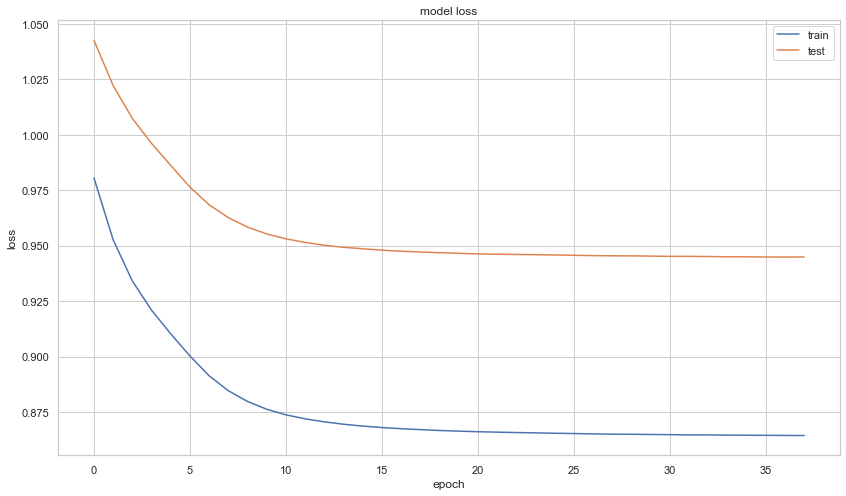

In [162]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

Calculate predictions by the autoencoder:

In [163]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((2415, 144), (2415, 144))

Calculate mean squared error.

In [164]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
1240,0.783822,0
177,1.195569,0
4524,0.934630,1
4087,0.883251,0
2070,0.712459,0


In [165]:
error_df.shape

(2415, 2)

In [166]:
error_df.reconstruction_error.describe()

count    2415.000000
mean        0.939070
std         2.417183
min         0.369772
25%         0.592926
50%         0.690799
75%         0.841253
max        84.863183
Name: reconstruction_error, dtype: float64

### Reconstruction errors for negative and positive value

Plot histogram of errors of reconstruction for normal data.

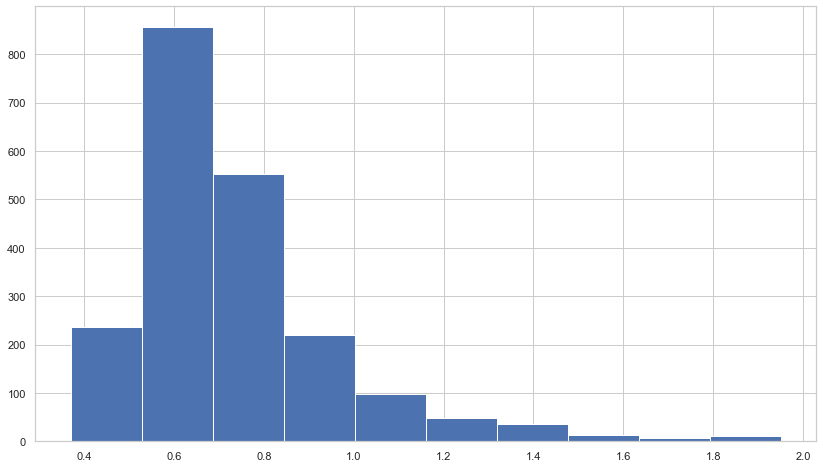

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 2)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

Compare distribution of reconstruction error for negative data and for positive data.

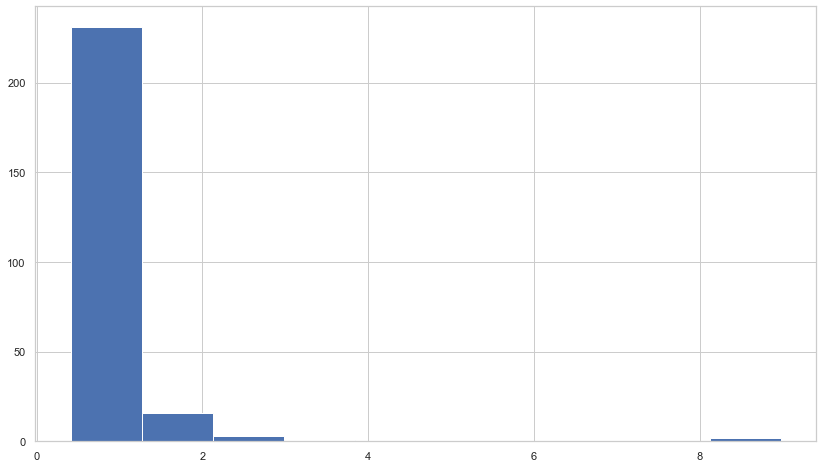

In [168]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

Errors of reconstruction of both type of data are similar.

In [169]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

Calculate ROC curve and AUC:

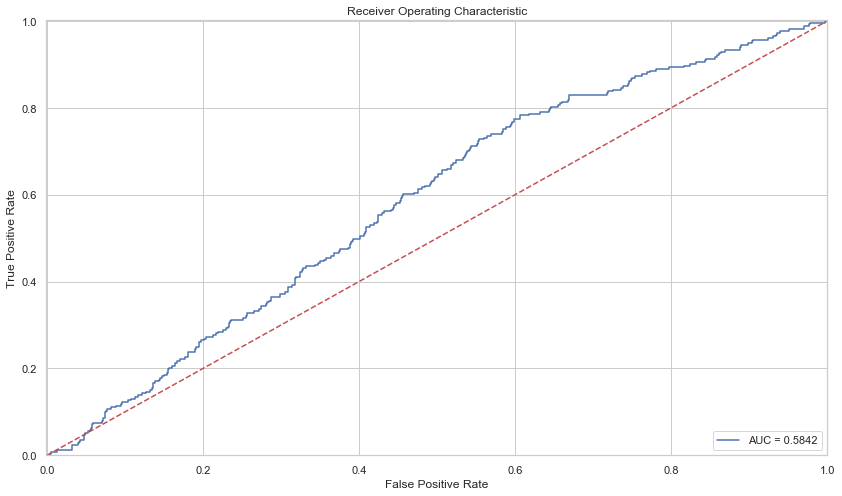

In [170]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The AUC for the autoencoder predictions is not high.

### Prediction
To detect anomaly based on prediction MSE select a high level quantile of the MSE sample that guarantees probability of type 1 error. Select 0.995 quantile of the reconstruction error for "normal" class.

In [171]:
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

1.8036164957745573

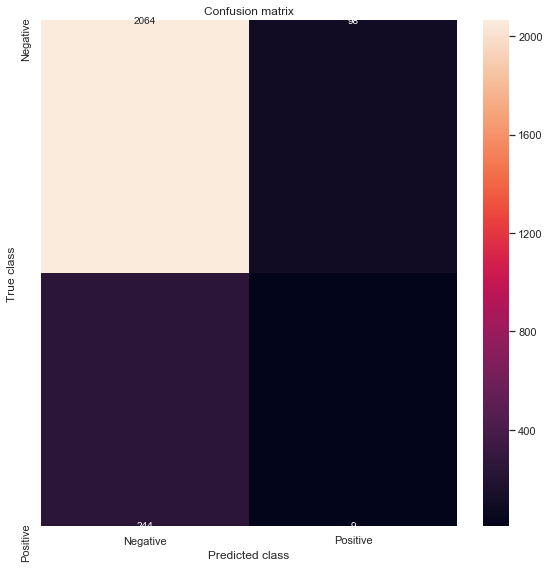

In [172]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.tight_layout()
plt.show()

In [173]:
# print classification report 
print(classification_report(error_df.true_class, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2162
           1       0.08      0.04      0.05       253

    accuracy                           0.86      2415
   macro avg       0.49      0.50      0.49      2415
weighted avg       0.81      0.86      0.83      2415



In [174]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(-0.01309033459346609, 0.8583850931677018)

## 5. Anomalies Detection using Classifier

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,
                             cohen_kappa_score, accuracy_score)
import sklearn.metrics as skm
from pylab import rcParams
import pickle

# Set some visualization parameters:
rcParams['figure.figsize'] = 14, 8
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Creating the model

In [176]:
input_dim = len(featuresList)
input_layer = Input(shape=(input_dim, ))
classifier = Dense(11, activation='relu')(input_layer)
classifier = Dropout(0.5)(classifier)
classifier = Dense(1, activation='sigmoid')(classifier)
classModel = Model(inputs=input_layer, outputs=classifier)
classModel.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 144)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 11)                1595      
_________________________________________________________________
dropout (Dropout)            (None, 11)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 12        
Total params: 1,607
Trainable params: 1,607
Non-trainable params: 0
_________________________________________________________________


Split the dataset into train and validation subsets:

In [177]:
train, test = train_test_split(Train, 
                               test_size=0.2, 
                               shuffle=True, 
                               stratify=Train['y'],
                               random_state=1)

In [178]:
nb_epoch = 150
batch_size = 256
adam = Adam(lr=0.0005)
classModel.compile(optimizer=adam, 
                    loss='mean_squared_error')

earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)

checkpointer = ModelCheckpoint(filepath="classifier.h5",
                               verbose=0,
                               save_best_only=True)

class_history = classModel.fit(x=train[featuresList], y=train['y'],
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test[featuresList], test['y']),
                    verbose=1,
                    callbacks=[earlystopping, checkpointer]).history

Epoch 1/150
38/38 [==============================] - 0s 8ms/step - loss: 0.3663 - val_loss: 0.3317
Epoch 2/150
38/38 [==============================] - 0s 1ms/step - loss: 0.3242 - val_loss: 0.2780
Epoch 3/150
38/38 [==============================] - 0s 2ms/step - loss: 0.2847 - val_loss: 0.2330
Epoch 4/150
38/38 [==============================] - 0s 2ms/step - loss: 0.2499 - val_loss: 0.1965
Epoch 5/150
38/38 [==============================] - 0s 2ms/step - loss: 0.2202 - val_loss: 0.1688
Epoch 6/150
38/38 [==============================] - 0s 2ms/step - loss: 0.2010 - val_loss: 0.1476
Epoch 7/150
38/38 [==============================] - 0s 2ms/step - loss: 0.1776 - val_loss: 0.1320
Epoch 8/150
38/38 [==============================] - 0s 2ms/step - loss: 0.1659 - val_loss: 0.1201
Epoch 9/150
38/38 [==============================] - 0s 2ms/step - loss: 0.1523 - val_loss: 0.1117
Epoch 10/150
38/38 [==============================] - 0s 2ms/step - loss: 0.1439 - val_loss: 0.1050
Epoch 11/

38/38 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0564
Epoch 84/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0562
Epoch 85/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0560
Epoch 86/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0559
Epoch 87/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0558
Epoch 88/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0555
Epoch 89/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0553
Epoch 90/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0552
Epoch 91/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0550
Epoch 92/150
38/38 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0548
Epoch 93/150


### Evaluating Classifier

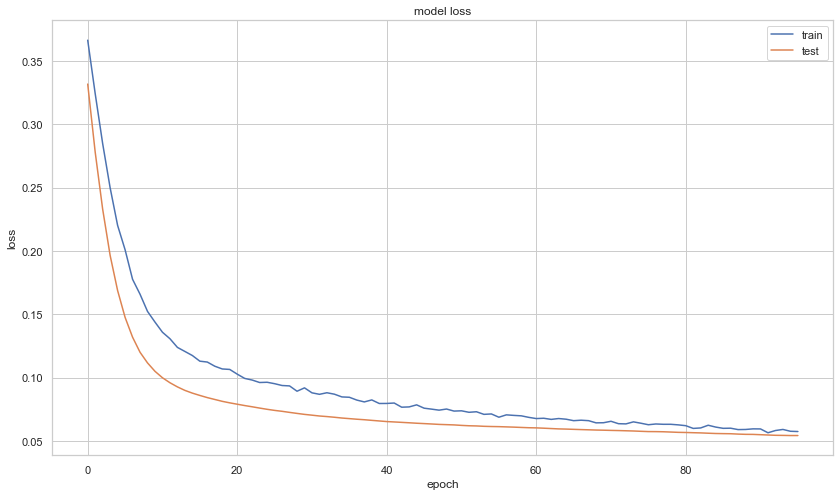

In [179]:
plt.plot(class_history['loss'])
plt.plot(class_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [180]:
fittedClassifier = load_model('classifier.h5')

In [181]:
testProb = fittedClassifier.predict(test[featuresList])

In [182]:
testProb = testProb[:,0]
class_prob_df = pd.DataFrame({'probabilities': testProb,
                        'true_class': test['y']})

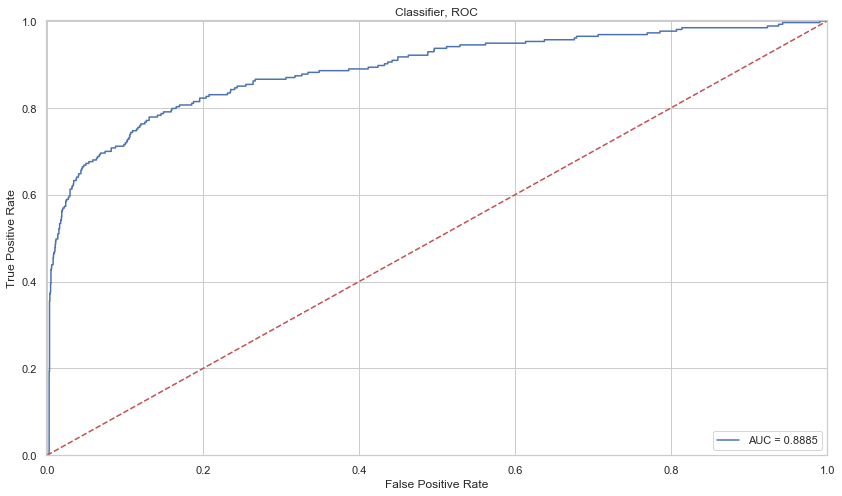

In [183]:
fpr, tpr, thresholds = roc_curve(class_prob_df.true_class, class_prob_df.probabilities)
roc_auc = auc(fpr, tpr)

plt.title('Classifier, ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

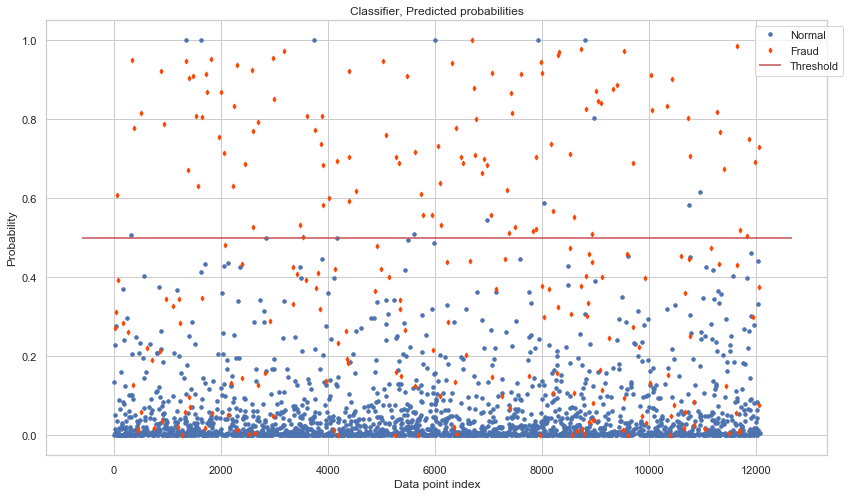

In [184]:
class_threshold = 0.5
groups = class_prob_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.probabilities, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(class_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Classifier, Predicted probabilities")
plt.ylabel("Probability")
plt.xlabel("Data point index")
plt.show();

[[2149   13]
 [ 142  111]]


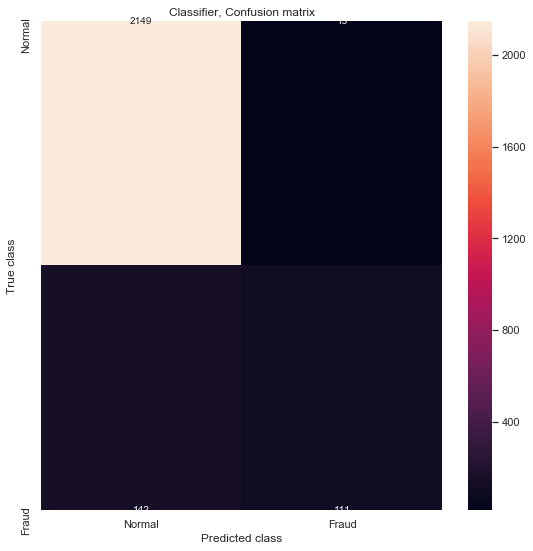

In [185]:
LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > class_threshold else 0 for e in class_prob_df.probabilities.values]
conf_matrix = confusion_matrix(class_prob_df.true_class, y_pred)
print(conf_matrix)

plt.figure(figsize=(9, 9))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Classifier, Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [186]:
# print classification report 
print(classification_report(class_prob_df.true_class, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2162
           1       0.90      0.44      0.59       253

    accuracy                           0.94      2415
   macro avg       0.92      0.72      0.78      2415
weighted avg       0.93      0.94      0.93      2415



In [187]:
print("Cohen's Kappa = ", cohen_kappa_score(class_prob_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(class_prob_df.true_class, y_pred))

Cohen's Kappa =  0.5584285210407792
Accuracy =  0.9358178053830227


Both vaule of this classifier model is better. As the result, the classifier model is going to use for prediction dataset.